In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from models.ckan import cKAN, train_model_ckan, rearrange_data, create_dataset

In [2]:
lag = 3  # number of lags
T = 1000  # number of time points
num_series = 5  # number of time series

batch_size = 32
epochs = 5000
lr = 5e-2
sparsity = 0.4

dim_input = num_series * lag
dim_output = 1

lamb = 0.004

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Simulate data
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=sparsity)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)  # add one new dimension for X

([], [])

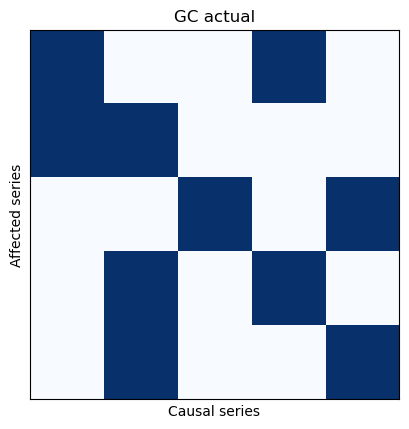

In [4]:
plt.imshow(GC, cmap='Blues')
plt.title('GC actual')
plt.ylabel('Affected series')
plt.xlabel('Causal series')
plt.xticks([])
plt.yticks([])

In [5]:
print("X_np shape: ", X_np.shape)
print('beta shape: ', beta.shape)
print('GC shape: ', GC.shape)
print('X shape: ', X.shape)

X_np shape:  (1000, 5)
beta shape:  (5, 15)
GC shape:  (5, 5)
X shape:  torch.Size([1, 1000, 5])


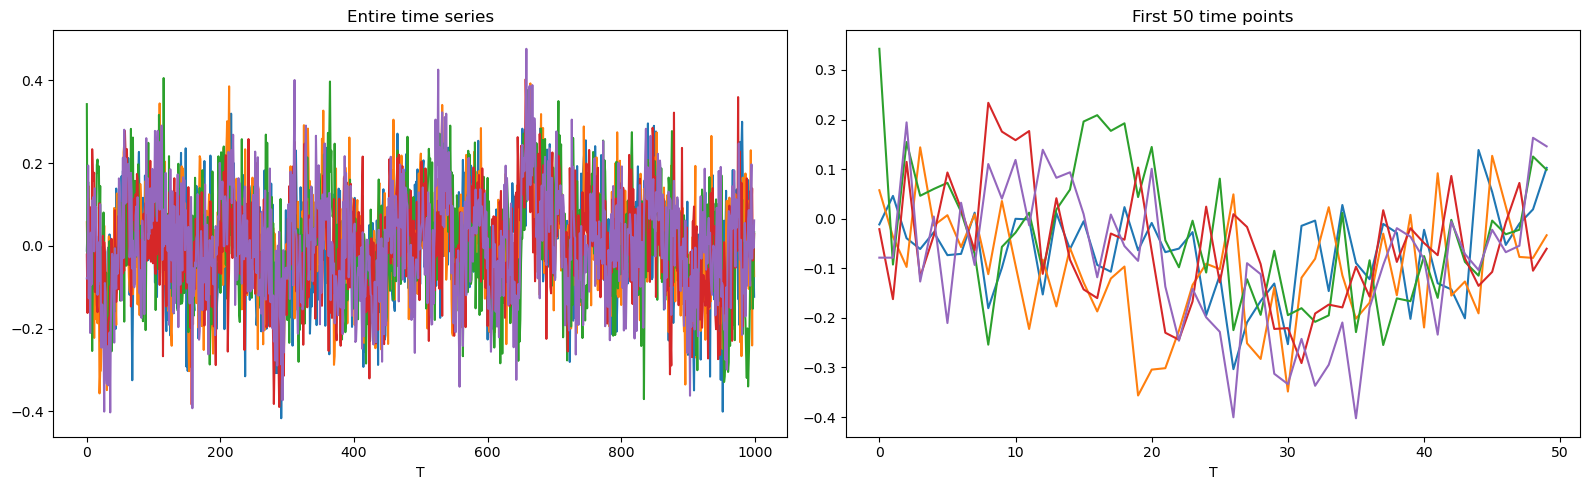

In [6]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

## Create cKAN and Train

### KAN with width=64 for hidden layer

In [7]:
# # setup the model
# hidden = [num_series*lag, 64, 1]
# ckan = cKAN(num_series, lag, hidden, prun_th=0.0001)
# result = train_model_ckan(ckan, X, max_iter=1)

In [8]:
# # plot loss
# plt.plot(result)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Loss function')

In [9]:
# scores = ckan.get_scores()
# print(scores)

# # plot the heatmap of the GC matrix
# plt.figure()
# plt.imshow(scores, cmap='Blues')
# plt.title('GC estimated')
# plt.ylabel('Affected series')
# plt.xlabel('Causal series')
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [10]:
# GC

### KAN with width=32

In [11]:
medium_hidden = [num_series*lag, 16, 8, 1]
ckan_medium = cKAN(num_series, lag, medium_hidden, prun_th=0.001, grid=4, k=4)
result_medium = train_model_ckan(ckan_medium, X, max_iter=epochs, opt='Adam', lamb=lamb)

| train_loss: 2.62e-01 | test_loss: 1.81e-01 | reg: 7.41e+01 | : 100%|█| 5000/5000 [06:42<00:00, 12.
| train_loss: 2.18e-01 | test_loss: 1.40e+00 | reg: 1.04e+01 | : 100%|█| 5000/5000 [07:24<00:00, 11.
| train_loss: 6.04e+03 | test_loss: 6.04e+03 | reg: 8.91e+02 | : 100%|█| 5000/5000 [07:31<00:00, 11.
| train_loss: 1.19e-01 | test_loss: 1.19e-01 | reg: 0.00e+00 | : 100%|█| 5000/5000 [07:07<00:00, 11.
| train_loss: 1.42e-01 | test_loss: 1.33e-01 | reg: 2.19e+01 | : 100%|█| 5000/5000 [06:52<00:00, 12.


Text(0.5, 1.0, 'Loss function')

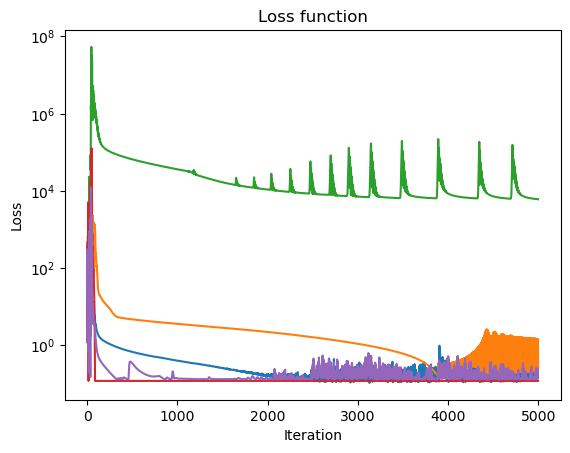

In [17]:
# plot loss
plt.plot(result_medium)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss function')

In [13]:
scores_medium = ckan_medium.get_scores()
print(scores_medium)

# # plot the heatmap of the GC matrix
# plt.figure()
# plt.imshow(scores_medium, cmap='Blues')
# plt.title('GC estimated')
# plt.ylabel('Affected series')
# plt.xlabel('Causal series')
# plt.xticks([])
# plt.yticks([])
# plt.show()

[[ 10.260738     7.8970294    8.692688     6.888249     7.2861185 ]
 [  0.60416204   0.91833115   0.7138988    0.78350735   1.044916  ]
 [ 90.91332    104.45041    129.97015    147.43652    100.07971   ]
 [  0.           0.           0.           0.           0.        ]
 [  2.2300174    1.9645562    1.5989814    1.992698     1.9590664 ]]


In [14]:
GC

array([[1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1]])

In [15]:
scores_medium

array([[ 10.260738  ,   7.8970294 ,   8.692688  ,   6.888249  ,
          7.2861185 ],
       [  0.60416204,   0.91833115,   0.7138988 ,   0.78350735,
          1.044916  ],
       [ 90.91332   , 104.45041   , 129.97015   , 147.43652   ,
        100.07971   ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  2.2300174 ,   1.9645562 ,   1.5989814 ,   1.992698  ,
          1.9590664 ]], dtype=float32)

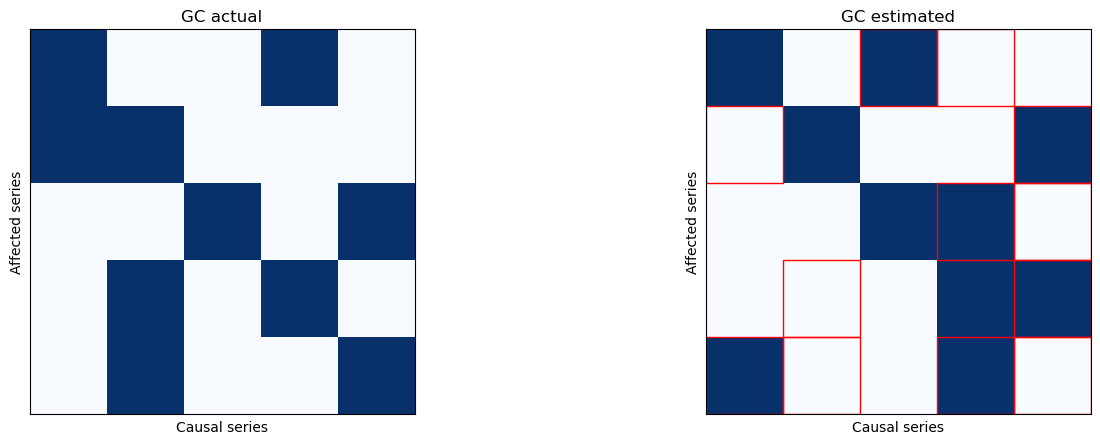

In [16]:
# set the first six largest values in each row of scores_medium to 1, the rest to 0
scores_medium_bin = np.zeros(scores_medium.shape)
for i in range(scores_medium.shape[0]):
    idx = np.argsort(scores_medium[i])[::-1][:2]
    scores_medium_bin[i, idx] = 1

# plot the heatmap of the GC matrix
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))

axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(scores_medium_bin, cmap='Blues')
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC)):
    for j in range(len(GC)):
        if GC[i, j] != scores_medium_bin[i, j]:
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

# print true variable usage

